In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import re
from tifffile import imread
from sklearn import preprocessing
import math
import scipy
from scipy.signal import windows
from scipy import stats
import seaborn as sns
import networkx as nx
from skimage.segmentation import find_boundaries

# local imports
sys.path.append('../')
import cyclePred as cp

In [2]:
"""Load all important info """

FILE = "D3"

""" Load the image and the segmentation """
fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/images/{FILE}.raw.tiff"
img_hr = imread(fpath)
print(f"{img_hr.shape=}")

fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/images/{FILE}.prepared.tiff"
img = imread(fpath)
print(f"{img.shape=}")

fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/images/{FILE}.segmented.tiff"
seg = imread(fpath)
print(f"{seg.shape=}")



"""load the cells """
fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/segmentation/{FILE}.celldata.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")


"""Load the tracks """
fpath = f"/scratch/indikar_root/indikar1/cstansbu/pf-sync/tracks/{FILE}.tracks.full.csv"
tdf = pd.read_csv(fpath)

# add the cycle delineation
alpha = 0.05
tdf = cp.getPhases(tdf, alpha, correct=True)

# add track length and time variables
minsPerFrame = 20
tdf['trackLen'] = tdf.groupby('ID')['x'].transform('count')
tdf['Time'] = (tdf['t'] * minsPerFrame) / 60

print(f"{tdf.shape=}")
print()
print(tdf.columns)
tdf.head()

TiffFrame 432: missing required tags
OME series: expected 432 frames, got 433


img_hr.shape=(3, 144, 2168, 2995, 3)
img.shape=(3, 144, 1084, 1498)
seg.shape=(144, 1084, 1498)
cdf.shape=(204091, 20)
alpha=0.05 ntests=612687 8.371859083755595e-08
tdf.shape=(204666, 47)

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'prob', 'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_prepared', 'c1_logFoldChange_prepared',
       'c2_logFoldChange_prepared', 'c0_pval_prepared', 'c1_pval_prepared',
       'c2_pval_prepared', 'c0_logFoldChange_processed',
       'c1_logFoldChange_processed', 'c2_logFoldChange_processed',
       'c0_pval_processed', 'c1_pval_processed', 'c2_pval

,ID,t,x,y,z,parent,root,state,generation,dummy,...,c2_pval_prepared,c0_logFoldChange_processed,c1_logFoldChange_processed,c2_logFoldChange_processed,c0_pval_processed,c1_pval_processed,c2_pval_processed,phase,trackLen,Time
0,393,0,147.970588,934.036765,0.0,393,393,5,0,False,...,1.0,-1.298156,3.420278,3.708074,1.000000e+00,1.239994e-45,1.370196e-43,S/G2/M,144,0.0
1,983,0,873.311927,340.018349,0.0,983,983,5,0,False,...,1.0,-1.246484,3.234826,4.042474,1.000000e+00,6.699638e-39,2.824379e-42,S/G2/M,79,0.0
2,469,0,1369.102326,1031.362791,0.0,469,469,5,0,False,...,1.0,0.179430,3.685880,3.634172,2.427678e-01,1.384222e-64,6.984623e-48,S/G2/M,106,0.0
3,710,0,971.926471,114.294118,0.0,710,710,5,0,False,...,1.0,-0.944516,2.039747,0.041521,1.000000e+00,1.821942e-16,3.667619e-01,NA,143,0.0
4,1276,0,517.754098,252.065574,0.0,1276,1276,5,0,False,...,1.0,3.378128,1.839746,0.789941,5.732810e-16,3.163280e-14,1.611127e-06,G1,144,0.0


tid=136
pdf.shape=(85, 47)
cdx.shape=(85, 65)


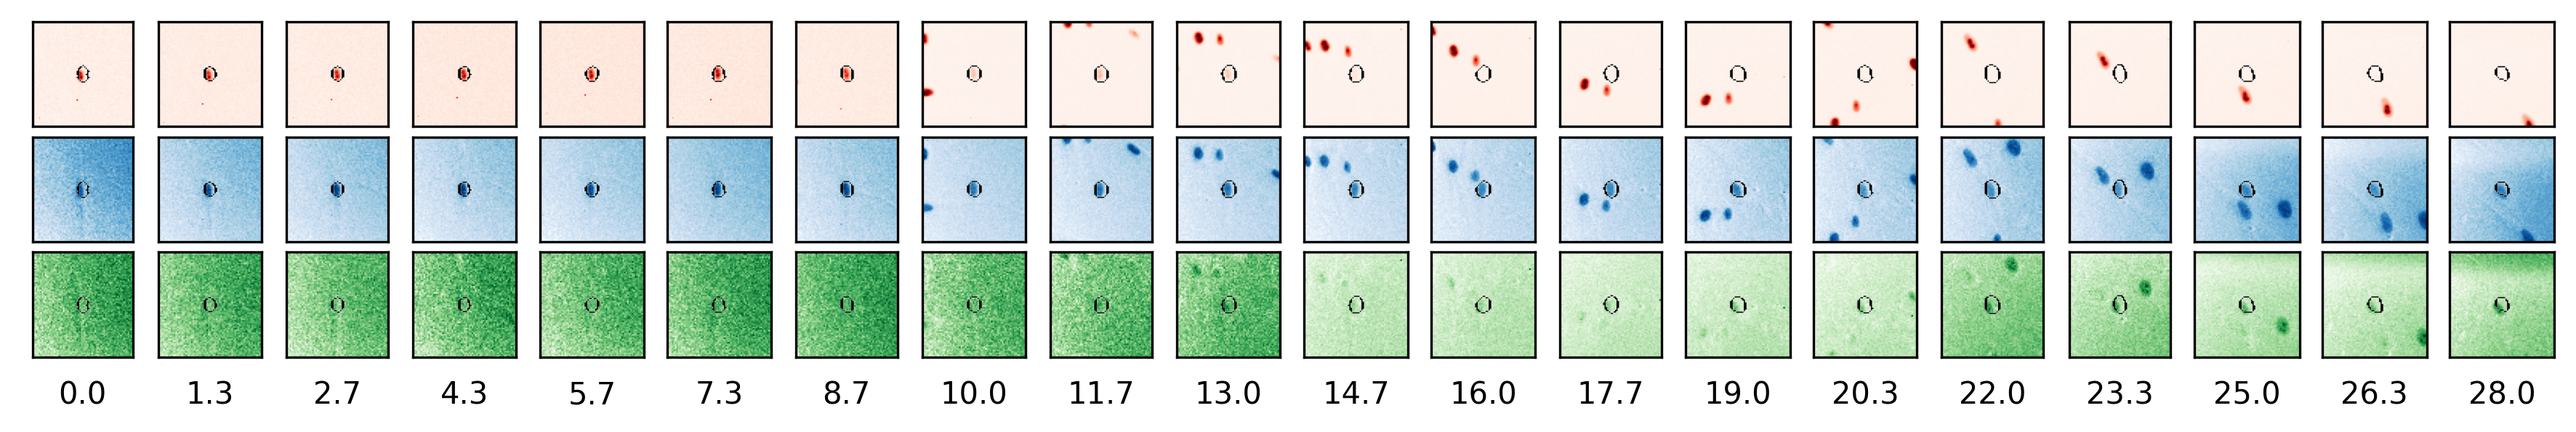

In [3]:
# get a good looking track
tid = np.random.choice(tdf['ID'], 1)[0]
# tid = 2081
# tid = 161
# tid = 2830
tid = 136
print(f"{tid=}")

pdf = tdf[tdf['ID'] == tid]
print(f"{pdf.shape=}")
pdf.head()

# get the slices from the cell data
cdx = pd.merge(cdf, 
               pdf, 
               how='left',
               left_on=['t', 'label'],
               right_on=['t', 'label'])

cdx = cdx[cdx['ID'].notna()] # drop all other tracks
print(f"{cdx.shape=}")

# refmort slices into lists: xmin, xmax, ymin, ymax
def getSlices(row):
    """A lamba apply function to reformt segmentation slices """
    coordStr = re.sub(r'[^\d.\s]+', "", row)
    splitter = coordStr.split()
    return [int(x) for x in splitter]

def widenWindow(img, window, ws):
    """A function to widen the window around a segementation
    by ws pixel """
    c, t, y, x, = img.shape
    ymin, ymax, xmin, xmax = window
    
    xmin = np.max([0, xmin-ws]) 
    xmax = np.min([x, xmax+ws])
    ymin = np.max([0, ymin-ws])
    ymax = np.min([y, ymax+ws]) 
    return ymin, ymax, xmin, xmax

def translateSlice(img, img_hr, window):
    """A function to get the corresponding slice 
    from a high definition image """
    _, _, y, x = img.shape
    _, _, y_hr, x_hr, _ = img_hr.shape

    ymin, ymax, xmin, xmax = window

    ymin_hr = int((ymin * y_hr) / y)
    ymax_hr = int((ymax * y_hr) / y)
    xmin_hr = int((xmin * x_hr) / x)
    xmax_hr = int((xmax * x_hr) / x)
    
    return ymin_hr, ymax_hr, xmin_hr, xmax_hr

    
trans = matplotlib.colors.colorConverter.to_rgba('white', alpha = 0)
col= matplotlib.colors.colorConverter.to_rgba('black', alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', [trans, col],512)
    

cdx['window'] = cdx['slice'].apply(lambda x: getSlices(x))
cdx = cdx.sort_values(by='t').reset_index(drop=True)

ntime = 20
inds = np.linspace(0, len(cdx)-1, ntime).astype(int)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 2
plt.rcParams['figure.facecolor'] = 'None'
plt.rcParams['axes.facecolor'] = 'None'

fig, axs = plt.subplots(3, ntime)

pltCount = 0
for idx in inds:
    row = cdx.loc[idx] 
    t = int(row['t'])
    label = row['label']
    window = row['window'] 
    
    # get the images
    xmin, xmax, ymin, ymax = widenWindow(img, window, 30)
    img_t = img[:, t ,xmin:xmax, ymin:ymax]


    axs[0, pltCount].imshow(img_t[0, :, :], cmap='Reds')
    axs[1, pltCount].imshow(img_t[1, :, :], cmap='Blues')
    axs[2, pltCount].imshow(img_t[2, :, :], cmap='Greens')
    
    # get the segmentation
    seg_t = np.where(seg[t, :, :] == label, 1, 0)
    bounds = find_boundaries(seg_t, 
                             connectivity=1,
                             mode='outer', 
                             background=0)
    
    bounds = bounds[xmin:xmax, ymin:ymax]

    # overlay the segmentatio
    axs[0, pltCount].imshow(bounds, cmap=cmap_rb)
    axs[1, pltCount].imshow(bounds, cmap=cmap_rb)
    axs[2, pltCount].imshow(bounds, cmap=cmap_rb)
    

    axs[2, pltCount].set_xlabel(f"{row['Time']:.1f}")
    pltCount += 1
    

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [4]:
cdx.columns

Index(['area', 'area_convex_x', 'area_filled_x', 'axis_major_length_x',
       'axis_minor_length_x', 'centroid_y', 'centroid_x', 'eccentricity_x',
       'intensity', 'intensity_max', 'intensity_min', 'intensity_mean',
       'label', 'orientation_x', 'perimeter_x', 'solidity_x', 'slice',
       'circularity_x', 't', 'prob_x', 'ID', 'x', 'y', 'z', 'parent', 'root',
       'state', 'generation', 'dummy', 'area_x', 'area_y', 'area_convex_y',
       'area_filled_y', 'axis_major_length_y', 'axis_minor_length_y',
       'eccentricity_y', 'c0_intensity_max', 'c1_intensity_max',
       'c2_intensity_max', 'c0_intensity_min', 'c1_intensity_min',
       'c2_intensity_min', 'c0_intensity_mean', 'c1_intensity_mean',
       'c2_intensity_mean', 'prob_y', 'orientation_y', 'perimeter_y',
       'solidity_y', 'circularity_y', 'c0_logFoldChange_prepared',
       'c1_logFoldChange_prepared', 'c2_logFoldChange_prepared',
       'c0_pval_prepared', 'c1_pval_prepared', 'c2_pval_prepared',
       'c0_logF

([], [])

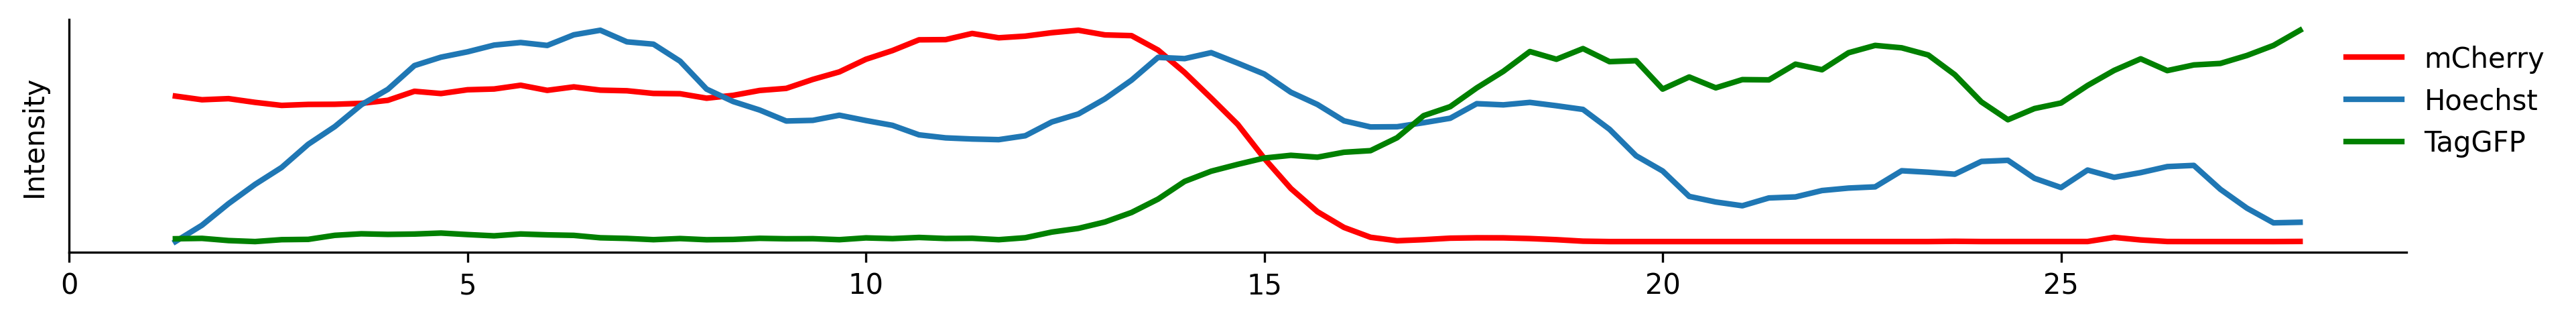

In [5]:
pdf = cdx.copy()

smooth = 5
cols = ['c0_intensity_mean',
        'c1_intensity_mean',
        'c2_intensity_mean',
       ]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 1.5
plt.rcParams['figure.facecolor'] = 'None'
plt.rcParams['axes.facecolor'] = 'None'

colors = [
    'r',
    'C0',
    'g'
]

labels = [
    'mCherry',
    'Hoechst',
    'TagGFP',
]

for i, col in enumerate(cols):
    # outlier removal
    pdf[col] = pdf[col][(np.abs(stats.zscore(pdf[col])) < 3)]

    # smooth
    pdf[col] = pdf[col].rolling(smooth).mean()

    # handle nans by imputing over a large window
    pdf[col] = pdf[col].fillna(pdf[col].rolling(smooth+5,  min_periods=1).mean())

    # rescale the data
    min_max_scaler = preprocessing.MinMaxScaler()
    pdf[col] = min_max_scaler.fit_transform(pdf[col].to_numpy().reshape(-1, 1))

    # plot
    plt.plot(pdf['Time'], pdf[col], lw=2, c=colors[i], label=labels[i])

plt.legend()
sns.despine()
sns.move_legend(plt.gca(),
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.07, 1))
plt.ylabel('Intensity')
plt.yticks([])

# population dynamics 

In [6]:
def simpleSmooth(df, window=3):
    """A function to smooth the dataframe phases """
    df = df.sort_values(by=['ID', 't'])

    df['phaseCat'] = df['phase'].astype('category')
    df['code'] = df['phaseCat'].cat.codes
    df['code'] = df['code'].fillna(-1)
    df = df.reset_index(drop=True)
    codeMap = dict(enumerate(df['phaseCat'].cat.categories ) )

    print(codeMap)

    tracks = []

    for tid, track in df.groupby('ID'):
        # get the most common phase over the window
        track['modeCode'] = track['code'].rolling(window=window, 
                                                  min_periods=1, 
                                                  center=True,
                                                  closed='both').apply(lambda x: stats.mode(x, keepdims=True)[0])


        track['phaseMode'] = track['modeCode'].map(codeMap)
        tracks.append(track)

    tracks = pd.concat(tracks)
    return tracks


tdf = simpleSmooth(tdf, window=3)
print('done')

{0: 'G1', 1: 'G1/S', 2: 'NA', 3: 'S/G2/M'}
done


pdf.shape=(54864, 52)


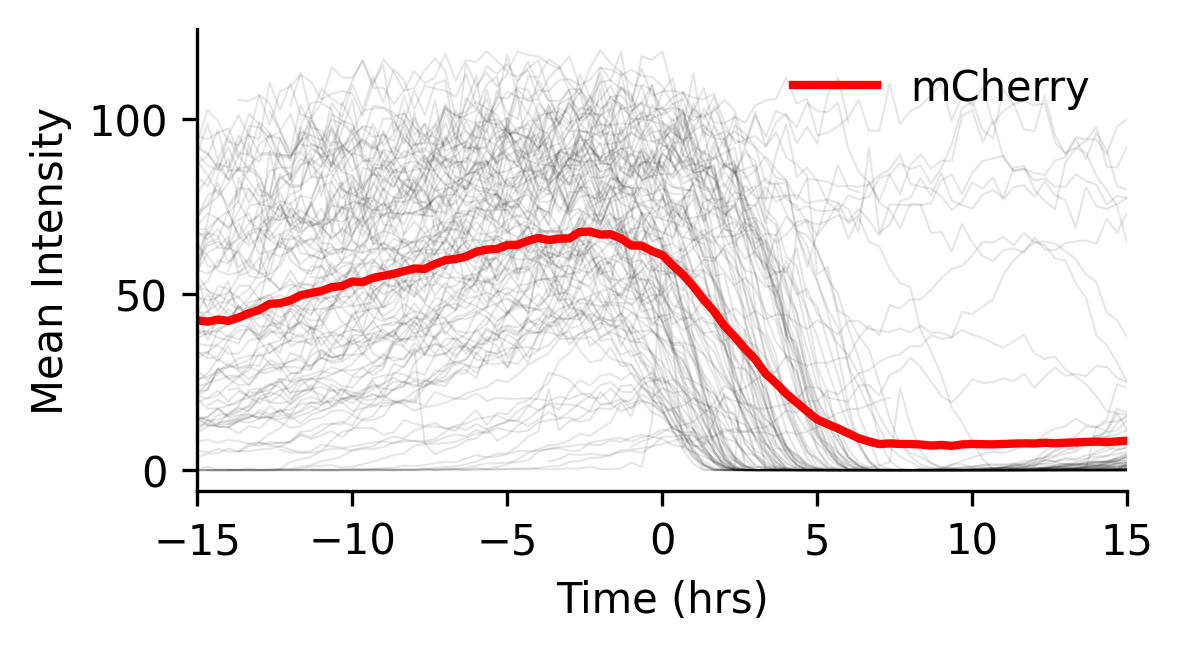

In [7]:
# time warping
pdf = tdf.copy()

col = 'c0_intensity_mean'

#max cutoff
max_thresh = 120
pdf['max_c2_int'] = pdf.groupby('ID')[col].transform('max')

pdf = pdf[pdf['max_c2_int'] < max_thresh]

# filter short tracks
pdf = pdf[pdf['trackLen'] == pdf['trackLen'].max()]
print(f"{pdf.shape=}")

# mark S phase entry
phase_entries = pdf.groupby(['ID', 'phase'])['t'].min().reset_index()

# pull out S phase entries
s_entries = phase_entries[phase_entries['phase'] == 'G1/S']
s_entries.columns = ['ID', 'phase', 's_entry']


# merge 'em back
pdf = pd.merge(pdf, s_entries[['ID', 's_entry']],
               how='left',
               left_on=['ID'],
               right_on=['ID'])



pdf['warp'] = pdf['t'] - pdf['s_entry']
pdf['warpTime'] = (pdf['warp'] * minsPerFrame) / 60

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2
plt.rcParams['figure.facecolor'] = 'None'
plt.rcParams['axes.facecolor'] = 'None'

min_max_scaler = preprocessing.MinMaxScaler()

for ID in pdf['ID'].unique():

    ddf = pdf[pdf['ID'] == ID].reset_index(drop=True)

    plt.plot(ddf['warpTime'],
             ddf[col],
             lw=0.5, 
             alpha=0.1,
             c='k')

gx = pdf.groupby('warpTime')[col].mean().reset_index()

plt.plot(gx['warpTime'],
         gx[col],
         lw=2, 
         c='r',
         label='mCherry')

plt.legend()
sns.move_legend(plt.gca(),
                frameon=False,
                loc='upper right')

plt.ylabel("Mean Intensity")
plt.xlabel("Time (hrs)")
plt.xlim([-15, 15])

sns.despine()

In [8]:
gx.head()

,warpTime,c0_intensity_mean
0,-45.333333,9.367347
1,-45.000000,0.032258
2,-44.666667,3.650794
3,-44.333333,4.117347
4,-44.000000,5.193878


In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def detectTransitions(tracks):
    print(tracks.shape)





def simpleSmooth(df, window=3):
    """A function to smooth the dataframe phases """
    df = df.sort_values(by=['ID', 't'])

    df['phaseCat'] = df['phase'].astype('category')
    df['code'] = df['phaseCat'].cat.codes
    df['code'] = df['code'].fillna(-1)
    df = df.reset_index(drop=True)
    codeMap = dict(enumerate(df['phaseCat'].cat.categories ) )

    print(codeMap)

    tracks = []

    for tid, track in df.groupby('ID'):
        # get the most common phase over the window
        track['modeCode'] = track['code'].rolling(window=window, 
                                                  min_periods=1, 
                                                  center=True,
                                                  closed='both').apply(lambda x: stats.mode(x, keepdims=True)[0])


        track['phaseMode'] = track['modeCode'].map(codeMap)
        tracks.append(track)

    tracks = pd.concat(tracks)
    return tracks


pdf = simpleSmooth(tdf, window=3)
print('done')

In [ ]:
pdf.head()